In [1]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.metrics import make_scorer, cohen_kappa_score
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv', index_col='id')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

## Data preprocessing

In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (3960, 81)
Test shape: (20, 58)


In [4]:
# handle missing value and convert from string to num in categorical features
train_cat_cols = train.select_dtypes(exclude='number').columns
for col in train_cat_cols: 
    train[col] = train[col].replace({'Spring':1,'Summer':2,"Fall":3,"Winter":4})
    train[col] = train[col].fillna(0)

test_cat_cols = test.select_dtypes(exclude='number').columns
for col in test_cat_cols:
    test[col] = test[col].replace({'Spring':1,'Summer':2,"Fall":3,"Winter":4})
    test[col] = test[col].fillna(0)

### PCIAT score ranges
- 0-30 => sii = 0
- 31-49 => sii = 1
- 50-79 => sii = 2
- 80-100 => sii = 3

In [5]:
PCIAT_cols = [val for val in train.columns[train.columns.str.contains('PCIAT')]] # Columns that contain "PCIAT"
PCIAT_cor = pd.DataFrame(train[PCIAT_cols].corr()['PCIAT-PCIAT_Total'].sort_values(ascending=False))
PCIAT_cor.style.background_gradient()

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
PCIAT-PCIAT_05,0.830993
PCIAT-PCIAT_15,0.823996
PCIAT-PCIAT_17,0.823708
PCIAT-PCIAT_03,0.823336
PCIAT-PCIAT_18,0.802030
PCIAT-PCIAT_02,0.788802
PCIAT-PCIAT_13,0.771990
PCIAT-PCIAT_08,0.770499
PCIAT-PCIAT_16,0.769422


In [6]:
print("Number of sii=0:",len(train[train['PCIAT-PCIAT_Total']<=30]))
print("Number of sii=1:",len(train[(30<train['PCIAT-PCIAT_Total'])&(train['PCIAT-PCIAT_Total']<50)]))
print("Number of sii=2:",len(train[(50<=train['PCIAT-PCIAT_Total'])&(train['PCIAT-PCIAT_Total']<80)]))
print("Number of sii=3:",len(train[train['PCIAT-PCIAT_Total']>=80]))

Number of sii=0: 1594
Number of sii=1: 730
Number of sii=2: 378
Number of sii=3: 34


### CHANGE 1: `sii` is still derived from the sum of of the NaN values => potentially incorrect SII 

In [7]:
train_with_sii = train[train['sii'].notna()][PCIAT_cols+['sii']]
train_with_sii[train_with_sii.isna().any(axis=1)].head()

,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,...,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii
id,,,,,,,,,,,,,,,,,,,,,
011e71c3,2.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,2.0,...,2.0,1.0,1.0,2.0,1.0,2.0,NaN,2.0,30.0,0.0
053d7d31,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
05bc318e,3.0,5.0,2.0,4.0,2.0,NaN,2.0,2.0,2.0,1.0,...,2.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,45.0,1.0
08159c5e,4.0,1.0,2.0,4.0,2.0,2.0,2.0,1.0,3.0,1.0,...,0.0,0.0,3.0,0.0,NaN,0.0,2.0,0.0,26.0,0.0
082df556,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,26.0,0.0


As you can see in row with **id=053d7d31** has `PCIAT-PCIAT_Total=0` although none of 20 questions was answered 

Now we need to recalculate `sii` and remove **unstable** row (row that contains mutiple possible `sii` values)

In [8]:
question_cols = [col for col in PCIAT_cols if col not in ['PCIAT-Season', 'PCIAT-PCIAT_Total']]

def recalc_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[question_cols].isna().sum() * 5
    if max_possible <= 30:
        return 0
    elif max_possible < 50:
        return 1
    elif max_possible < 80:
        return 2
    elif max_possible >= 80:
        return 3

train['recalc_sii'] = train.apply(recalc_sii, axis=1)

In [9]:
train[(train['recalc_sii'] != train['sii']) & (train['sii'].notna())]

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,recalc_sii
id,,,,,,,,,,,,,,,,,,,,,
011e71c3,2,15,0,3.0,70.0,2.0,21.177784,62.00,115.8,NaN,...,NaN,2.0,30.0,2.0,34.0,49.0,2.0,1.0,0.0,1.0
053d7d31,1,15,1,0.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,1.0,2.0,0.0,3.0
05bc318e,1,11,0,3.0,68.0,3.0,20.095643,59.50,101.2,NaN,...,3.0,2.0,45.0,3.0,41.0,58.0,1.0,2.0,1.0,2.0
08159c5e,4,17,1,3.0,75.0,0.0,NaN,NaN,NaN,NaN,...,2.0,0.0,26.0,4.0,30.0,43.0,4.0,2.0,0.0,1.0
082df556,4,16,0,2.0,45.0,1.0,16.774971,70.50,118.6,NaN,...,NaN,1.0,26.0,4.0,32.0,46.0,4.0,0.0,0.0,1.0
0fbb3ca5,4,15,0,1.0,55.0,1.0,19.024041,70.00,132.6,NaN,...,4.0,2.0,48.0,1.0,34.0,49.0,4.0,3.0,1.0,2.0
1551c806,3,18,1,1.0,60.0,4.0,21.014782,67.50,136.2,NaN,...,NaN,NaN,31.0,0.0,NaN,NaN,3.0,2.0,1.0,2.0
23418fa2,1,7,1,2.0,75.0,1.0,14.575555,47.00,45.8,NaN,...,1.0,0.0,21.0,1.0,37.0,53.0,1.0,0.0,0.0,1.0
2bad0db7,2,11,0,3.0,68.0,2.0,18.545256,55.00,79.8,NaN,...,0.0,1.0,29.0,2.0,45.0,63.0,2.0,2.0,0.0,1.0


There are **17 rows** that contain `sii` != `recalc_sii` 

My approach is delete all these rows from train dataset

In [10]:
changed_condition = (train['sii']!=train['recalc_sii']) & (train['sii'].notna())
print("Number of rows in train before drop:", train.shape[0])
train = train[~changed_condition]
print("Number of rows in train after drop:", train.shape[0])
train.drop(columns=['recalc_sii'],inplace=True)

Number of rows in train before drop: 3960
Number of rows in train after drop: 3943


### END CHANGE 1

In [11]:
PCIAT_cols.remove('PCIAT-PCIAT_Total')
backup_train = train
train.drop(columns=PCIAT_cols,inplace=True)

In [12]:
print("Number of possible values for PIU:",len(train['PreInt_EduHx-computerinternet_hoursday'].unique())) # It can be 0,1,2,3 or NaN

Number of possible values for PIU: 5


In [13]:
print("Correlation between PIU and sii:", train['PreInt_EduHx-computerinternet_hoursday'].corr(train['sii']))

Correlation between PIU and sii: 0.3363662906666555


In [14]:
feature_correlation = pd.DataFrame(train.drop(columns=['sii','BIA-BIA_BMI','SDS-SDS_Total_Raw']).corr()['PCIAT-PCIAT_Total'].sort_values(ascending=False))
feature_correlation.style.background_gradient()

# drop BIA-BIA_BMI because it has been already calculated in `Physical-BMI`
# Same reason with 'SDS-SDS_Total_Raw'

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
Physical-Height,0.421205
Basic_Demos-Age,0.410153
PreInt_EduHx-computerinternet_hoursday,0.373430
Physical-Weight,0.353618
Physical-Waist_Circumference,0.324571
FGC-FGC_CU,0.288407
Physical-BMI,0.240281
SDS-SDS_Total_T,0.238541
PAQ_A-Season,0.220809


In [15]:
# only take columns that have |correlation| >= 0.1
remain = feature_correlation[abs(feature_correlation['PCIAT-PCIAT_Total'])>=0.1].drop('PCIAT-PCIAT_Total')
remain_features = remain.index.tolist()
remain.style.background_gradient()

,PCIAT-PCIAT_Total
Physical-Height,0.421205
Basic_Demos-Age,0.410153
PreInt_EduHx-computerinternet_hoursday,0.373430
Physical-Weight,0.353618
Physical-Waist_Circumference,0.324571
FGC-FGC_CU,0.288407
Physical-BMI,0.240281
SDS-SDS_Total_T,0.238541
PAQ_A-Season,0.220809
FGC-FGC_PU,0.197464


In [16]:
print("Number of features before remove low correlate features:", feature_correlation.shape[0] - 2) # minus 2 because we don't count 'sii' and 'PCIAT-PCIAT_Total' as features
print("Number of remain features:", len(remain_features))

Number of features before remove low correlate features: 55
Number of remain features: 19


In [17]:
missing = pd.DataFrame(train.isna().sum().sort_values(ascending=False)).rename(columns={0:"Missing Count"})
missing['Data Loss(%)'] = missing['Missing Count'] / train.shape[0] * 100
missing.style.background_gradient()

,Missing Count,Data Loss(%)
PAQ_A-PAQ_A_Total,3474,88.105503
Fitness_Endurance-Time_Sec,3208,81.359371
Fitness_Endurance-Time_Mins,3208,81.359371
Fitness_Endurance-Max_Stage,3205,81.283287
Physical-Waist_Circumference,3048,77.301547
FGC-FGC_GSND_Zone,2887,73.218362
FGC-FGC_GSD_Zone,2886,73.193000
FGC-FGC_GSD,2875,72.914025
FGC-FGC_GSND,2875,72.914025
PAQ_C-PAQ_C_Total,2227,56.479838


In [18]:
drop_threshold = 70 # Drop column that misses more than 70% of its value
remain_features = [ft for ft in remain_features if ft in missing[missing['Data Loss(%)']<=70].index.tolist()]
remain_features
print("Number of remain features:", len(remain_features))

Number of remain features: 16


In [19]:
remain_features

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'FGC-FGC_CU',
 'Physical-BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'Physical-Systolic_BP',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

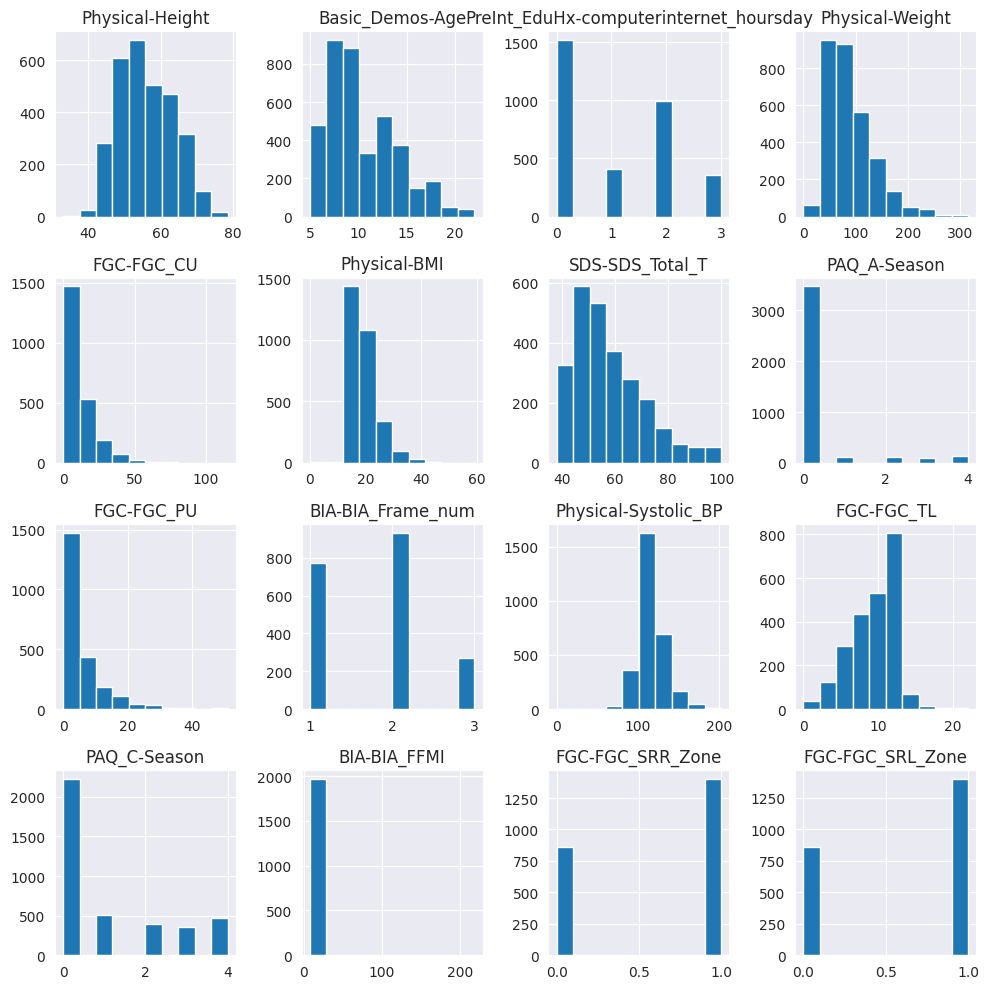

In [20]:
train[remain_features].hist(figsize=(10,10), grid = True)
plt.tight_layout()

## Train Model

I (Hoang) use XGB here (Khanh and Hung will test other models)

In [21]:
nonNaN_train = train.dropna(subset=['sii'])
X_train, X_test = nonNaN_train[remain_features], test[remain_features]
target_train = nonNaN_train['PCIAT-PCIAT_Total']

In [22]:
def scale(raw,coef):
    return raw*coef

# Convert PCIAT_Total score -> category
def score_to_category(scores):
    scores = np.array(scores)*1.252
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins

def quadratic_kappa(y_pred, y_true):
    y_true_categories, y_pred_categories = score_to_category(y_true), score_to_category(y_pred)
    return cohen_kappa_score(y_true_categories, y_pred_categories, weights='quadratic')

In [23]:
scorer = make_scorer(quadratic_kappa, greater_is_better=True)
params = {'max_depth': 3, 'n_estimators': 59, 'learning_rate': 0.07327652118259573, 'subsample': 0.5968194045365575, 'colsample_bytree': 0.9123669348125403}
skf = StratifiedKFold(n_splits=10)
model = xgb.XGBRegressor(**params)
scores = cross_val_score(model, X_train, target_train, cv=skf, scoring=scorer)
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.36515467 0.44486447 0.50554249 0.48467013 0.45665304 0.4259105
 0.52267819 0.43448384 0.43966307 0.50536223]
Mean QWK Score: 0.45849826295978324


In [24]:
model.fit(X_train,target_train)
feature_imp = pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

Basic_Demos-Age                           0.277483
PreInt_EduHx-computerinternet_hoursday    0.102912
SDS-SDS_Total_T                           0.077073
Physical-Height                           0.067885
Physical-Weight                           0.064563
FGC-FGC_SRR_Zone                          0.058283
FGC-FGC_CU                                0.055763
FGC-FGC_PU                                0.042009
PAQ_A-Season                              0.038420
FGC-FGC_SRL_Zone                          0.037404
PAQ_C-Season                              0.033410
Physical-BMI                              0.033164
FGC-FGC_TL                                0.030872
Physical-Systolic_BP                      0.030196
BIA-BIA_Frame_num                         0.025656
BIA-BIA_FFMI                              0.024908
dtype: float32

In [25]:
preds = model.predict(X_test)
preds = pd.Series(score_to_category(preds))
preds.index = test.index
preds.to_csv('submission.csv')